# Aperiodic Methods: Spectral Fitting

Fitting spectral methods on simulated power spectra.

In [29]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats.mstats import normaltest

In [30]:
# Import custom code
import sys; from pathlib import Path
sys.path.append(str(Path('..').resolve()))

from apm import syn
from apm.fit import *
from apm.fake import *
from apm.plts.psd import *
from apm.plts.fake import _color_red_or_green

from apm.core.db import APMDB
from apm.core.io import save_pickle, load_pickle

In [31]:
# Housekeeping
db = APMDB()

# Check current path
db.syns_path

'/Users/tom/Documents/Research/1-Projects/1-Current/AperiodicMethods/2-Data/syns'

## Check out PSD generation and test fitting

In [32]:
# Generate a single synthetic test PSD
exp_val = 1
noise = 0.1
oscs = syn.gen_osc_def
fs, psd = syn.sim_psd([3, 40], exp_val, syn.gen_osc_def, noise)

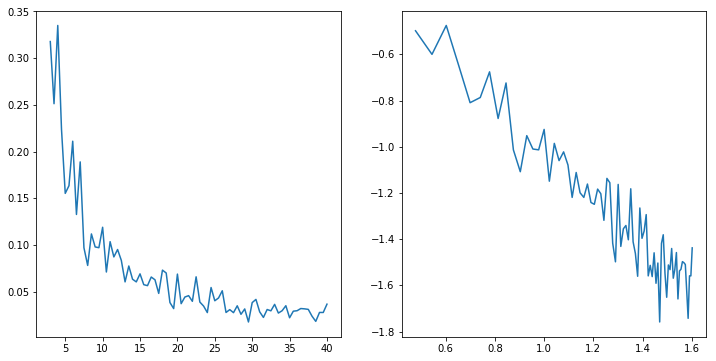

In [7]:
# Two subplots, the axes array is 1-d
plt_psd_both(fs, psd);

In [27]:
# Test out fits
print('True exponent value is ', str(exp_val), '\n')
print('OLS fit: \t', fit_ols(fs, psd))
print('RLM fit: \t', fit_rlm(fs, psd))
print('RLM-EA fit: \t', fit_rlm_alph(fs, psd))
print('RLM-EO fit: \t', fit_rlm_oscs(fs, psd))
print('RAN fit: \t', fit_ransac(fs, psd))
print('RAN-EA fit: \t', fit_ransac_alph(fs, psd))
print('RAN-EO fit: \t', fit_ransac_oscs(fs, psd))
print('EXP fit: \t', fit_exp(fs, psd))
print('EXP-EA fit: \t', fit_exp_alph(fs, psd))
print('EXP-EO fit: \t', fit_exp_oscs(fs, psd))
print('FOOOF fit: \t', fit_fooof(fs, psd))

True exponent value is  1 

OLS fit: 	 -0.9889131662310354
RLM fit: 	 -0.9866264949852765
RLM-EA fit: 	 -0.9932606141751175
RLM-EO fit: 	 -0.9840585153865178
RAN fit: 	 -0.9008350367564838
RAN-EA fit: 	 -1.1062990969250608
RAN-EO fit: 	 -1.0034138676022004
EXP fit: 	 -0.9889131666233352
EXP-EA fit: 	 -0.9980230905138345
EXP-EO fit: 	 -0.9917289513064819
FOOOF fit: 	 -1.015577072828852


## Run a bunch of synthetic fits

In [11]:
# Settings
n_psds = 50
f_range = [3, 40]
exp_val = 1
noi_val = 0.05

# Simulate a group of PSDs
freqs, psds = syn.sim_n_psds(n_psds, f_range, exp_val, syn.gen_osc_def(), noi_val)

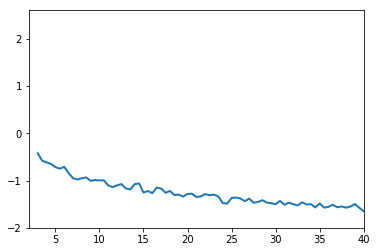

In [12]:
# Plot example synthetic PSD from the group
plt_psd_1(freqs, psds[:, 10], False)

In [13]:
# # Check out some of the synthetic plots
# for ind, psd in enumerate(psds.T):
#     if ind < 5:
#         plt.figure()
#         plt.plot(freqs, psd)

In [14]:
# Initialize and set up for synthetic data testing
syns = SynFits()
syns.get_fit_funcs()

In [15]:
# Check the fitting functions being used
print(list(syns.fit_funcs.keys()))

['OLS', 'RLM', 'RLM-EA', 'RLM-EO', 'RAN', 'RAN-EA', 'RAN-EO', 'EXP', 'EXP-EA', 'EXP-EO', 'FOOOF']


In [16]:
# Fit spectra: this fits all methods
syns.fit_spectra(exp_val, freqs, psds)

In [17]:
# Calculate metrics
avgs = syns.calc_avg_errs()
perc_good = syns.calc_perc_good()

In [28]:
# Check errors per fitting method
print('AVERAGE FIT ERRORS')
print_res(avgs)

AVERAGE FIT ERRORS
   EXP      		 0.01515
   OLS      		 0.01515
   EXP-EA   		 0.01655
   RAN      		 0.01687
   RLM      		 0.01694
   RLM-EA   		 0.01923
   RLM-EO   		 0.02393
   EXP-EO   		 0.02549
   FOOOF    		 0.02599
   RAN-EA   		 0.02750
   RAN-EO   		 0.03161


In [19]:
# Check errors per fitting method
print('PERCENTAGE FITS BELOW ERROR THRESHOLD')
print_res(perc_good)

PERCENTAGE FITS BELOW ERROR THRESHOLD
   OLS      		 0.70000
   EXP      		 0.70000
   RAN      		 0.66000
   RLM      		 0.64000
   EXP-EA   		 0.64000
   RLM-EA   		 0.60000
   RLM-EO   		 0.52000
   FOOOF    		 0.48000
   EXP-EO   		 0.48000
   RAN-EA   		 0.46000
   RAN-EO   		 0.44000


In [20]:
# 
df = pd.DataFrame(syns.errs)

In [21]:
# Check the correlation structure between fit erros
df.corr()

,OLS,RLM,RLM-EA,RLM-EO,RAN,RAN-EA,RAN-EO,EXP,EXP-EA,EXP-EO,FOOOF
OLS,1.000000,0.953435,0.733207,0.321884,0.829628,0.344236,0.254936,1.000000,0.742439,0.364770,0.387393
RLM,0.953435,1.000000,0.790138,0.312579,0.837644,0.342024,0.241718,0.953435,0.762655,0.346589,0.370923
RLM-EA,0.733207,0.790138,1.000000,0.304185,0.628556,0.524546,0.259850,0.733207,0.960224,0.350147,0.287721
RLM-EO,0.321884,0.312579,0.304185,1.000000,0.301761,0.074653,0.919318,0.321884,0.329651,0.991272,0.608236
RAN,0.829628,0.837644,0.628556,0.301761,1.000000,0.294576,0.254929,0.829628,0.593824,0.343090,0.320356
RAN-EA,0.344236,0.342024,0.524546,0.074653,0.294576,1.000000,0.088291,0.344236,0.531176,0.103040,0.041750
RAN-EO,0.254936,0.241718,0.259850,0.919318,0.254929,0.088291,1.000000,0.254936,0.291688,0.913030,0.364797
EXP,1.000000,0.953435,0.733207,0.321884,0.829628,0.344236,0.254936,1.000000,0.742439,0.364770,0.387393
EXP-EA,0.742439,0.762655,0.960224,0.329651,0.593824,0.531176,0.291688,0.742439,1.000000,0.379920,0.303994
EXP-EO,0.364770,0.346589,0.350147,0.991272,0.343090,0.103040,0.913030,0.364770,0.379920,1.000000,0.635290


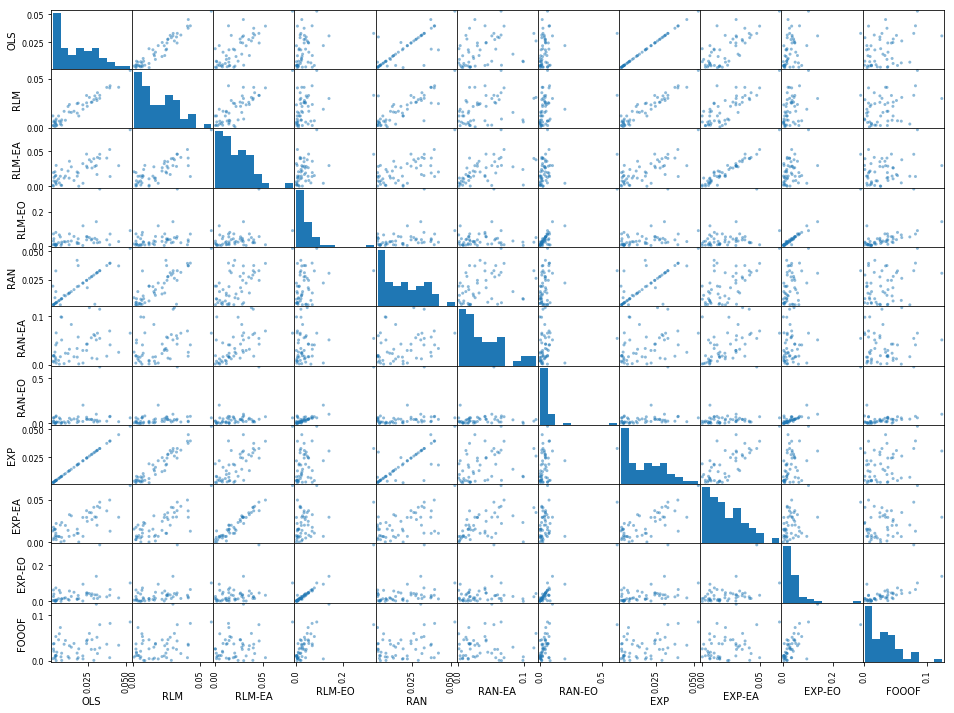

In [22]:
# Plot data distributions and inter-relations
pd.plotting.scatter_matrix(df, figsize=[16, 12]);

In [23]:
# Apply a normal test across fit-error distributions
normalities = df.apply(normaltest)

# Check which results of normal test
nt_df = pd.DataFrame([dat[1] for dat in normalities.values], index=normalities.index)
nt_df.style.applymap(_color_red_or_green)

,0
OLS,0.134072
RLM,0.197278
RLM-EA,0.00113658
RLM-EO,8.05598e-17
RAN,0.102554
RAN-EA,0.012749
RAN-EO,1.42517e-21
EXP,0.134072
EXP-EA,0.0514486
EXP-EO,1.04595e-16


In [24]:
# Save out synthetic fit data to pickle
#save_pickle(syns.errs, 'SynFits_test.p', db.syns_path)

In [25]:
# Check available synthetic fit files
syn_files = db.check_files('syns')
f_ind = syn_files.index('SynFits_test.p')

In [26]:
# Load synthetic fit data from pickle file
dat = load_pickle(syn_files[f_ind], db.syns_path)
syn_dat = SynFits()
syn_dat.errs = dat